## 1. Import packages

In [1]:
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
import albumentations as A

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
ROOT_PATH = '../lgg-mri-segmentation/kaggle_3m/'

## 2. Explore Data

### Creating DataFrame

In [2]:
mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

In [3]:
def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
1,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
2,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0
3,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,1
4,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,../lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874...,0


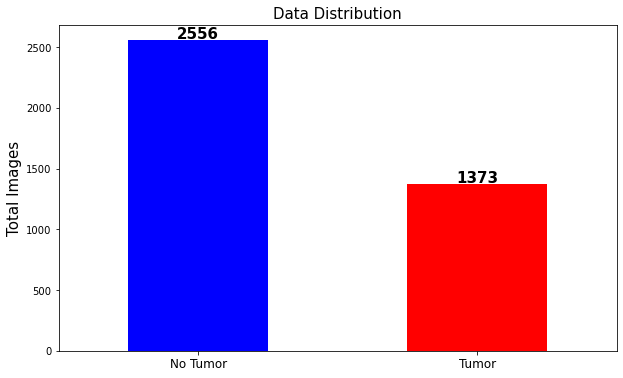

In [4]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

### Split data into `train`/`validation`/`test` set

In [5]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15)
train_df = train_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


### Visualize Image with Mask

(-0.5, 2604.5, 520.5, -0.5)

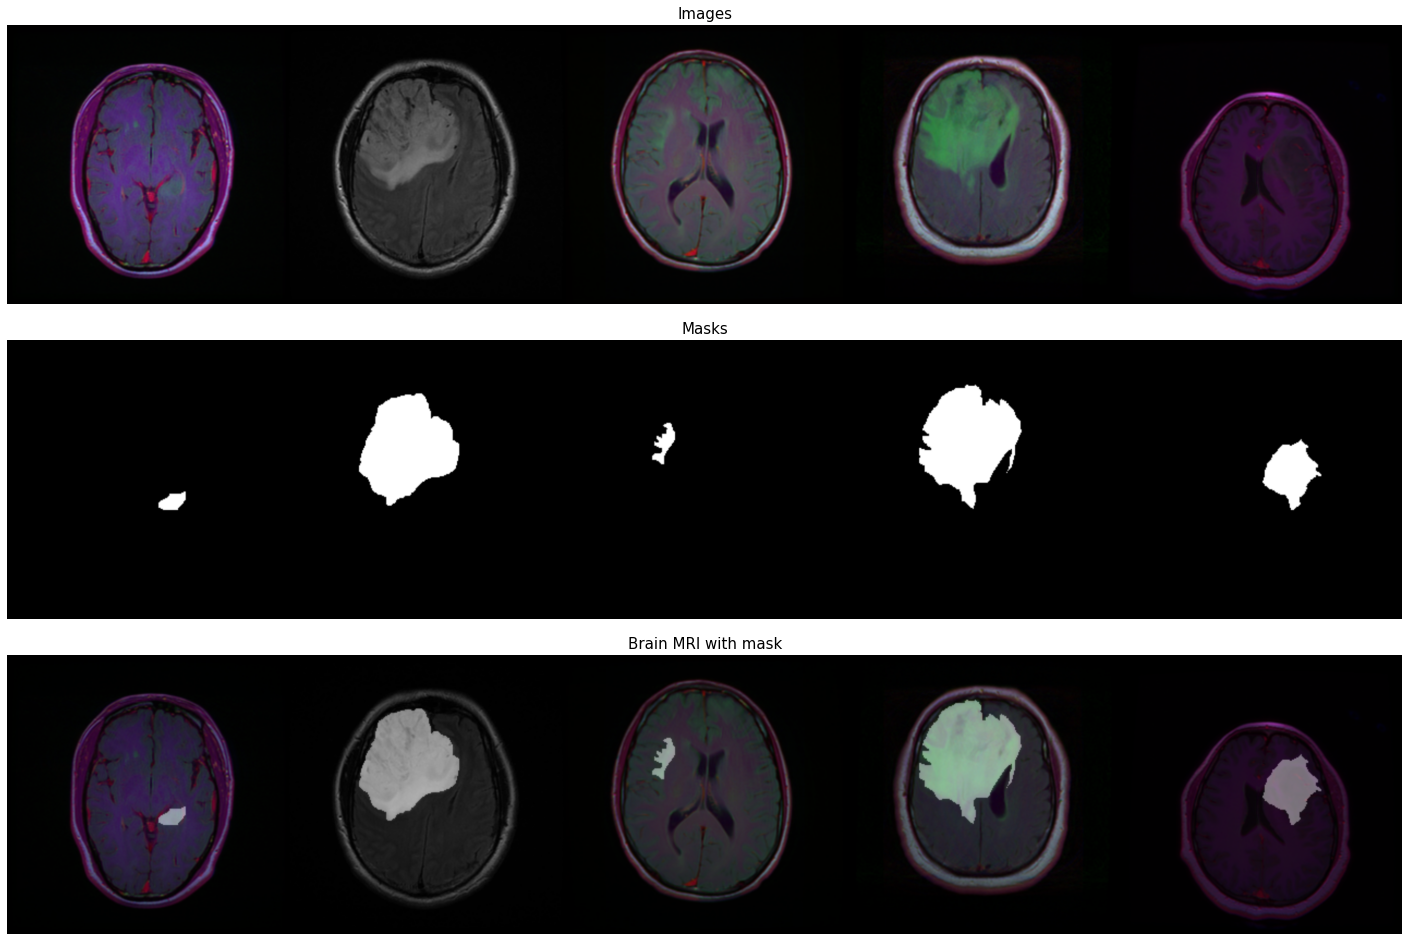

In [6]:
IMG_SIZE = 521
images = []
masks = []
df_positive = df[df['diagnosis']==1].sample(5).values
for data in df_positive:
    img = cv2.resize(cv2.imread(data[0]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

## 3. Data Generator and Augmentation

In [7]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i = 0
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
        if image is True:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img * std + mean).astype(np.float32)
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img); 
        plt.axis('off')
        i += 1
    return plt.show()

In [8]:
class BrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)
        
        return image, mask
    
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])
val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])
test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

### Create dataset

In [9]:
train_dataset = BrainDataset(train_df, train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=26, shuffle=True, num_workers=2)

val_dataset = BrainDataset(val_df, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=26, shuffle=True, num_workers=2)

test_dataset = BrainDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=26, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([26, 3, 128, 128])
torch.Size([26, 1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

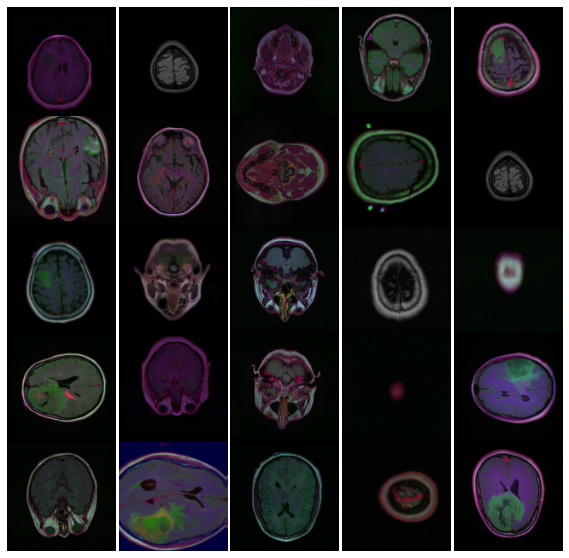

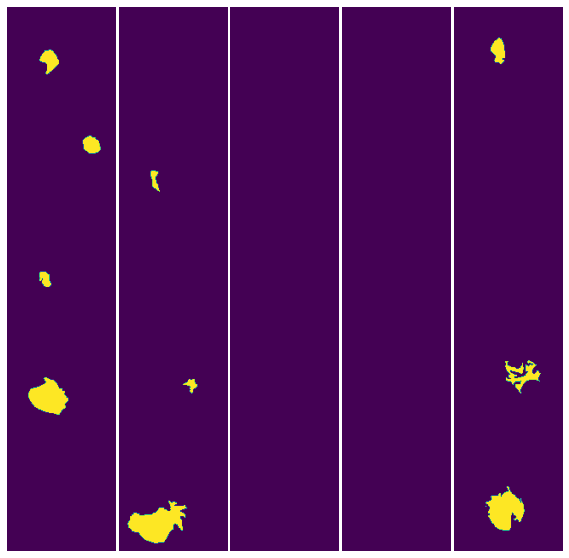

In [10]:
images, masks = next(iter(train_dataloader))
print(images.shape)
print(masks.shape)
show_aug(images)
show_aug(masks, image=False)

## 4. Create Model

In [11]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


## 4.1 Create model using smp 

In [17]:
import segmentation_models_pytorch as smp

In [30]:
model_smp = smp.Unet('efficientnet-b2',in_channels=3, encoder_weights='imagenet',classes=1, activation='sigmoid', encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [34]:
#print(model_smp)
model= model_smp.to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


## 5. Metric and Loss Function

In [35]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

## 6. Train Model

In [36]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

In [37]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            losses.append(loss.item())
            train_iou.append(train_dice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print('Epoch : {}/{}'.format(epoch+1, num_epochs))
        print('loss: {:.3f} - dice_coef: {:.3f} - val_dice_coef: {:.3f}'.format(np.array(losses).mean(),
                                                                               np.array(train_iou).mean(),
                                                                               val_mean_iou))
    return loss_history, train_history, val_history

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 100
loss_history, train_history, val_history = train_model(train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.00it/s]


Epoch : 1/100
loss: 0.780 - dice_coef: 0.573 - val_dice_coef: 0.766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.17it/s]


Epoch : 2/100
loss: 0.256 - dice_coef: 0.788 - val_dice_coef: 0.862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.31it/s]


Epoch : 3/100
loss: 0.210 - dice_coef: 0.819 - val_dice_coef: 0.893


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.49it/s]


Epoch : 4/100
loss: 0.208 - dice_coef: 0.819 - val_dice_coef: 0.829


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.76it/s]


Epoch : 5/100
loss: 0.178 - dice_coef: 0.844 - val_dice_coef: 0.912


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.44it/s]


Epoch : 6/100
loss: 0.152 - dice_coef: 0.867 - val_dice_coef: 0.903


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  8.99it/s]


Epoch : 7/100
loss: 0.152 - dice_coef: 0.867 - val_dice_coef: 0.890


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.87it/s]


Epoch : 8/100
loss: 0.144 - dice_coef: 0.873 - val_dice_coef: 0.929


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.92it/s]


Epoch : 9/100
loss: 0.137 - dice_coef: 0.880 - val_dice_coef: 0.918


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.76it/s]


Epoch : 10/100
loss: 0.147 - dice_coef: 0.870 - val_dice_coef: 0.928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.83it/s]


Epoch : 11/100
loss: 0.136 - dice_coef: 0.880 - val_dice_coef: 0.923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.62it/s]


Epoch : 12/100
loss: 0.132 - dice_coef: 0.883 - val_dice_coef: 0.878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.69it/s]


Epoch : 13/100
loss: 0.122 - dice_coef: 0.892 - val_dice_coef: 0.940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.00it/s]


Epoch : 14/100
loss: 0.123 - dice_coef: 0.891 - val_dice_coef: 0.943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.64it/s]


Epoch : 15/100
loss: 0.119 - dice_coef: 0.894 - val_dice_coef: 0.949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.08it/s]


Epoch : 16/100
loss: 0.118 - dice_coef: 0.896 - val_dice_coef: 0.934


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.89it/s]


Epoch : 17/100
loss: 0.119 - dice_coef: 0.895 - val_dice_coef: 0.931


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.87it/s]


Epoch : 18/100
loss: 0.118 - dice_coef: 0.896 - val_dice_coef: 0.881


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.00it/s]


Epoch : 19/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.919


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.69it/s]


Epoch : 20/100
loss: 0.112 - dice_coef: 0.901 - val_dice_coef: 0.943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.60it/s]


Epoch : 21/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.79it/s]


Epoch : 22/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.877


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.04it/s]


Epoch : 23/100
loss: 0.118 - dice_coef: 0.896 - val_dice_coef: 0.943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.82it/s]


Epoch : 24/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.934


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.30it/s]


Epoch : 25/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.72it/s]


Epoch : 26/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.934


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.23it/s]


Epoch : 27/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.36it/s]


Epoch : 28/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.947


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.16it/s]


Epoch : 29/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.70it/s]


Epoch : 30/100
loss: 0.114 - dice_coef: 0.900 - val_dice_coef: 0.928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.72it/s]


Epoch : 31/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.40it/s]


Epoch : 32/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.31it/s]


Epoch : 33/100
loss: 0.118 - dice_coef: 0.895 - val_dice_coef: 0.938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.03it/s]


Epoch : 34/100
loss: 0.119 - dice_coef: 0.894 - val_dice_coef: 0.949


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.60it/s]


Epoch : 35/100
loss: 0.119 - dice_coef: 0.894 - val_dice_coef: 0.942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  8.93it/s]


Epoch : 36/100
loss: 0.114 - dice_coef: 0.900 - val_dice_coef: 0.904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.37it/s]


Epoch : 37/100
loss: 0.116 - dice_coef: 0.898 - val_dice_coef: 0.928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.62it/s]


Epoch : 38/100
loss: 0.119 - dice_coef: 0.894 - val_dice_coef: 0.942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.88it/s]


Epoch : 39/100
loss: 0.116 - dice_coef: 0.898 - val_dice_coef: 0.930


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.35it/s]


Epoch : 40/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.939


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.77it/s]


Epoch : 41/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.928


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.71it/s]


Epoch : 42/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.930


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.77it/s]


Epoch : 43/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.941


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.29it/s]


Epoch : 44/100
loss: 0.116 - dice_coef: 0.898 - val_dice_coef: 0.945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.87it/s]


Epoch : 45/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  7.80it/s]


Epoch : 46/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.37it/s]


Epoch : 47/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.65it/s]


Epoch : 48/100
loss: 0.112 - dice_coef: 0.902 - val_dice_coef: 0.946


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.76it/s]


Epoch : 49/100
loss: 0.116 - dice_coef: 0.898 - val_dice_coef: 0.896


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.35it/s]


Epoch : 50/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.951


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.65it/s]


Epoch : 51/100
loss: 0.114 - dice_coef: 0.900 - val_dice_coef: 0.886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.06it/s]


Epoch : 52/100
loss: 0.112 - dice_coef: 0.901 - val_dice_coef: 0.949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.80it/s]


Epoch : 53/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.934


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.70it/s]


Epoch : 54/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.49it/s]


Epoch : 55/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.69it/s]


Epoch : 56/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.24it/s]


Epoch : 57/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.30it/s]


Epoch : 58/100
loss: 0.118 - dice_coef: 0.895 - val_dice_coef: 0.883


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.15it/s]


Epoch : 59/100
loss: 0.119 - dice_coef: 0.894 - val_dice_coef: 0.933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.62it/s]


Epoch : 60/100
loss: 0.120 - dice_coef: 0.894 - val_dice_coef: 0.938


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.32it/s]


Epoch : 61/100
loss: 0.113 - dice_coef: 0.900 - val_dice_coef: 0.947


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.10it/s]


Epoch : 62/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.888


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.15it/s]


Epoch : 63/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.918


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.72it/s]


Epoch : 64/100
loss: 0.118 - dice_coef: 0.895 - val_dice_coef: 0.957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.79it/s]


Epoch : 65/100
loss: 0.113 - dice_coef: 0.900 - val_dice_coef: 0.947


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.70it/s]


Epoch : 66/100
loss: 0.118 - dice_coef: 0.895 - val_dice_coef: 0.939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.78it/s]


Epoch : 67/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.34it/s]


Epoch : 68/100
loss: 0.112 - dice_coef: 0.901 - val_dice_coef: 0.950


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  7.89it/s]


Epoch : 69/100
loss: 0.121 - dice_coef: 0.893 - val_dice_coef: 0.945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.73it/s]


Epoch : 70/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.65it/s]


Epoch : 71/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.929


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.77it/s]


Epoch : 72/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.891


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.82it/s]


Epoch : 73/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.32it/s]


Epoch : 74/100
loss: 0.118 - dice_coef: 0.895 - val_dice_coef: 0.954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  9.26it/s]


Epoch : 75/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.79it/s]


Epoch : 76/100
loss: 0.116 - dice_coef: 0.898 - val_dice_coef: 0.870


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.57it/s]


Epoch : 77/100
loss: 0.113 - dice_coef: 0.900 - val_dice_coef: 0.931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.81it/s]


Epoch : 78/100
loss: 0.116 - dice_coef: 0.897 - val_dice_coef: 0.944


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  7.95it/s]


Epoch : 79/100
loss: 0.119 - dice_coef: 0.895 - val_dice_coef: 0.948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.80it/s]


Epoch : 80/100
loss: 0.114 - dice_coef: 0.900 - val_dice_coef: 0.949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.65it/s]


Epoch : 81/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.85it/s]


Epoch : 82/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:14<00:00,  8.04it/s]


Epoch : 83/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.936


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.66it/s]


Epoch : 84/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.65it/s]


Epoch : 85/100
loss: 0.117 - dice_coef: 0.896 - val_dice_coef: 0.943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.78it/s]


Epoch : 86/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.40it/s]


Epoch : 87/100
loss: 0.120 - dice_coef: 0.893 - val_dice_coef: 0.935


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.71it/s]


Epoch : 88/100
loss: 0.118 - dice_coef: 0.896 - val_dice_coef: 0.948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.76it/s]


Epoch : 89/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.937


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.73it/s]


Epoch : 90/100
loss: 0.113 - dice_coef: 0.900 - val_dice_coef: 0.881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.83it/s]


Epoch : 91/100
loss: 0.117 - dice_coef: 0.896 - val_dice_coef: 0.941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.80it/s]


Epoch : 92/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:16<00:00,  7.07it/s]


Epoch : 93/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.35it/s]


Epoch : 94/100
loss: 0.114 - dice_coef: 0.899 - val_dice_coef: 0.881


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.66it/s]


Epoch : 95/100
loss: 0.117 - dice_coef: 0.896 - val_dice_coef: 0.946


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.64it/s]


Epoch : 96/100
loss: 0.113 - dice_coef: 0.900 - val_dice_coef: 0.930


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.90it/s]


Epoch : 97/100
loss: 0.117 - dice_coef: 0.897 - val_dice_coef: 0.946


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.58it/s]


Epoch : 98/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:12<00:00,  8.95it/s]


Epoch : 99/100
loss: 0.115 - dice_coef: 0.899 - val_dice_coef: 0.948


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:13<00:00,  8.80it/s]


Epoch : 100/100
loss: 0.115 - dice_coef: 0.898 - val_dice_coef: 0.915


## 7. Train History

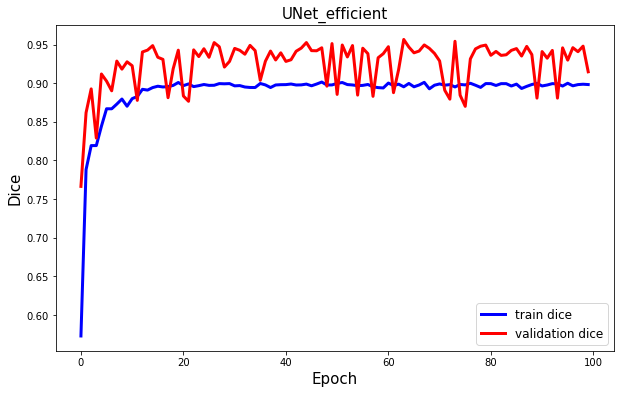

In [39]:
def plot_model_history(model_name, train_history, val_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="b")
    plt.plot(x, val_history, label='validation dice', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Dice", fontsize=15)

    plt.show()
    
plot_model_history('UNet_efficient', train_history, val_history, num_epochs)

## 8. Prediction

In [41]:
test_iou = compute_iou(model, test_dataloader)
print("Mean IoU: {:.3f}%".format(100*test_iou))

Mean IoU: 93.065%


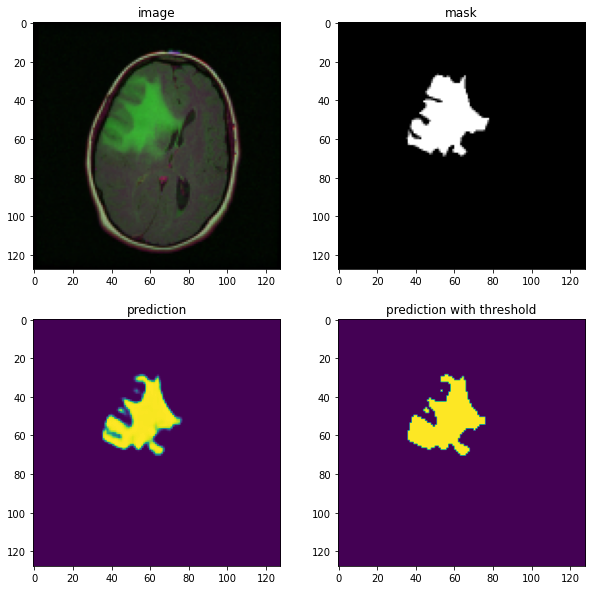

In [48]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

In [43]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values

def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[0]),(128, 128))
        image =  image / 255.
        ground_truth = cv2.resize(cv2.imread(test_sample[1], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(prediction)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[0]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
prediction_overlap_r = batch_preds_overlap(model, test_samples)

In [44]:
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [45]:
def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

title = "Predictions of UNet"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title, num)

In [46]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn = make_gif(title)

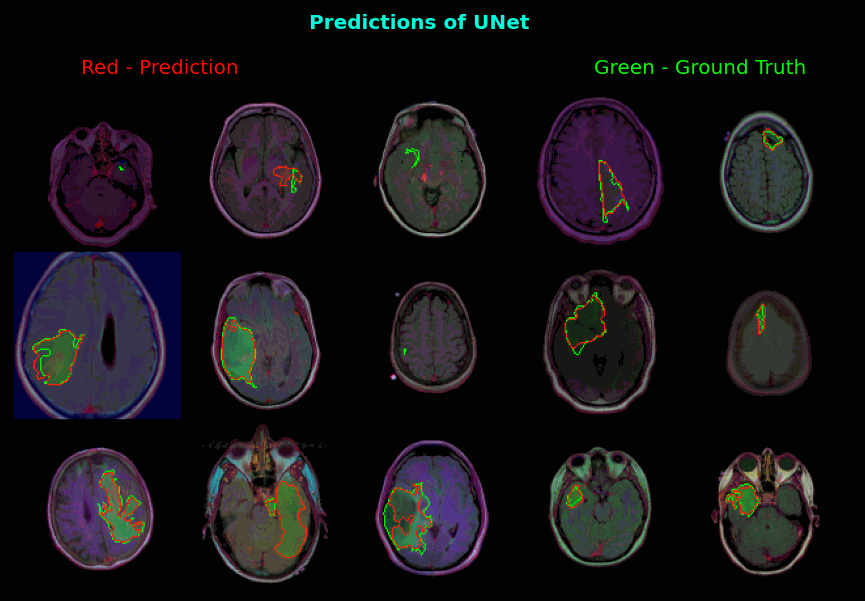

In [47]:
from IPython.display import Image as Image_display
with open(fn,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

In [26]:
torch.save(model.state_dict(), 'unet-model.ckpt')

### References
1: https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn<br>
2: https://github.com/milesial/Pytorch-UNet<br>
3: https://arxiv.org/pdf/1505.04597v1.pdf